In [1]:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/'Kaggle - Tabular Data Essay'

Mounted at /content/drive
/content/drive/MyDrive/Kaggle - Tabular Data Essay


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Prepare data

In [3]:
# List of kaggle competitions belonging to the tabular data playground series.
playground_list = [
    49201,
    49200,
    47790,
    47789,
    45894,
    45893,
    45892,
    45891,
    45890,
    44632,
    44631,
    44630,
    44629
]

In [14]:
# Process the competitions dataframe
competitions = pd.read_csv('Competitions.csv')
competitions['DeadlineDate'] = pd.to_datetime(competitions['DeadlineDate'])
competitions = (competitions
                .loc[competitions['HostSegmentTitle'] == 'Playground']
                .loc[competitions['Id'].isin(playground_list)]
                .sort_values(by='DeadlineDate', ascending=False)
                .rename(columns={'Id' : 'CompetitionId'})
)[['CompetitionId', 'Title']]

In [23]:
# Process the teams dataframe
teams = pd.read_csv('Teams.csv')

filtered_teams = (
    teams
    .loc[teams['PrivateLeaderboardRank'] <= 10]
    .merge(
      competitions,
      on = 'CompetitionId',
      how='inner'
    )
    .rename(columns={'Id' : 'TeamId'})
    .fillna(0)
)[['TeamId','Title', 'PrivateLeaderboardRank', 'WriteUpForumTopicId']]

<ipython-input-23-f30af957f5ac>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  teams = pd.read_csv('Teams.csv')


In [6]:
submissions = pd.read_csv('Submissions.csv')

In [24]:
reduced_submissions = submissions.merge(
    filtered_teams,
    on='TeamId',
    how='inner'
)
reduced_submissions = reduced_submissions[~reduced_submissions['IsAfterDeadline']]

In [26]:
submission_counts = reduced_submissions.groupby(['Title', 'TeamId', 'PrivateLeaderboardRank', 'WriteUpForumTopicId']).size().rename("SubmissionCount").reset_index()

## Build Chart displaying submissions per competition

In [36]:
# Define color based on rank
color_dict = color_dict = {1.0: '1st place', 2.0: '2nd place', 3.0: '3rd place'}

# Create a new column 'color' in the dataframe
submission_counts['color'] = submission_counts['PrivateLeaderboardRank'].map(color_dict)

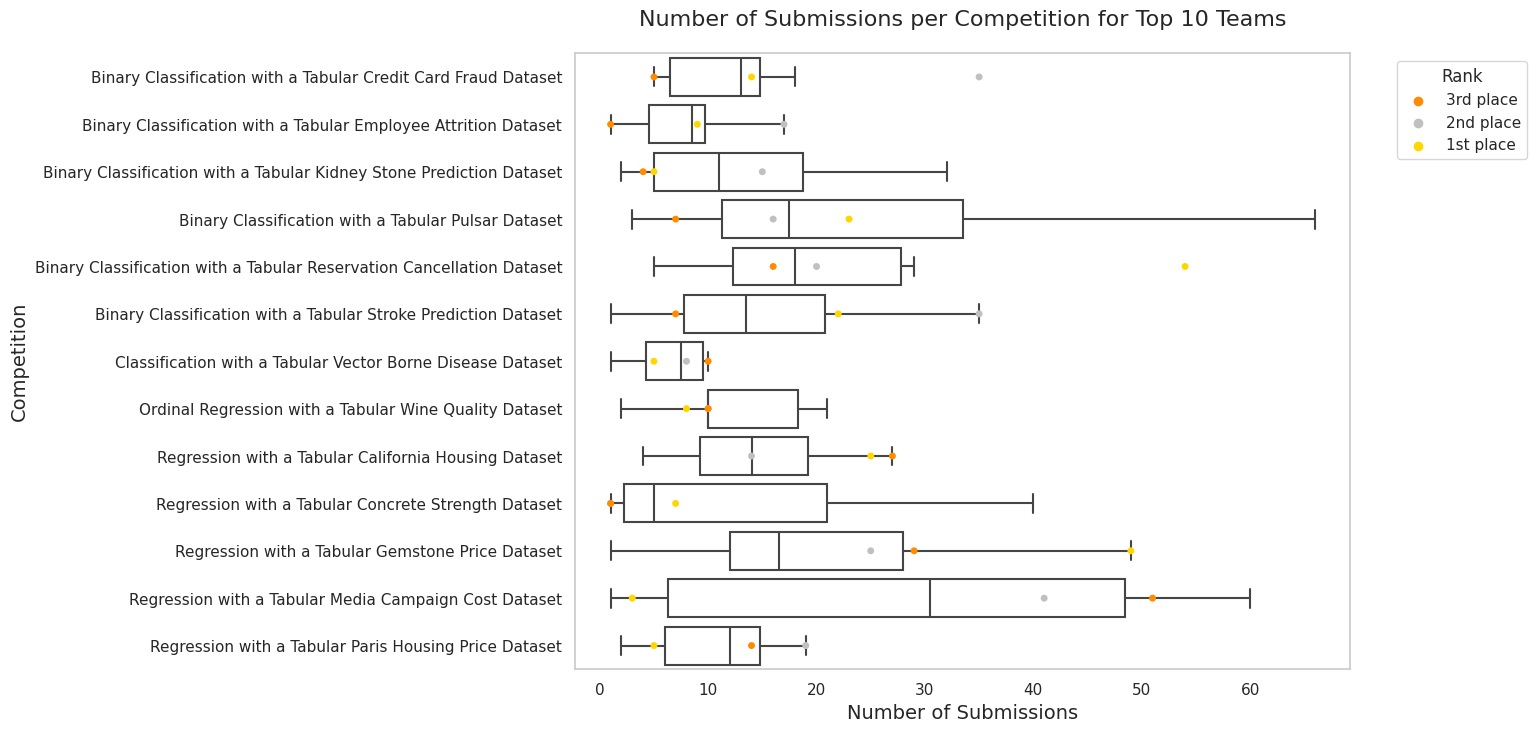

In [38]:
# Set the overall style
sns.set(style="whitegrid")

palette_dict = {'1st place': 'gold', '2nd place': 'silver', '3rd place': 'darkorange'}
# Create the stripplot
fig, ax = plt.subplots(figsize=(10, 8))

sns.boxplot(data=submission_counts, x="SubmissionCount", y="Title", boxprops=dict(facecolor='none', edgecolor='black'), fliersize=0) #transparent boxplot

# Making the stripplot
stripplot = sns.stripplot(data=submission_counts.loc[submission_counts.PrivateLeaderboardRank<=3], x="SubmissionCount", y="Title", hue='color', palette=palette_dict, ax=ax, jitter=False)

# Set the title and labels
plt.title('Number of Submissions per Competition for Top 10 Teams', fontsize=16, pad=20)
plt.xlabel('Number of Submissions', fontsize=14)
plt.ylabel('Competition', fontsize=14)

# Customize the legend
legend = stripplot.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Rank')

ax.grid(False)

# Show the plot
plt.savefig("submission_counts.png", bbox_inches = 'tight')  # 'bbox_inches = 'tight'' ensures the entire plot is saved

## Build chart showing write ups per article

<ipython-input-39-1a41bc025dbf>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.0f}%'.format(x*100) for x in ax.get_xticks()])


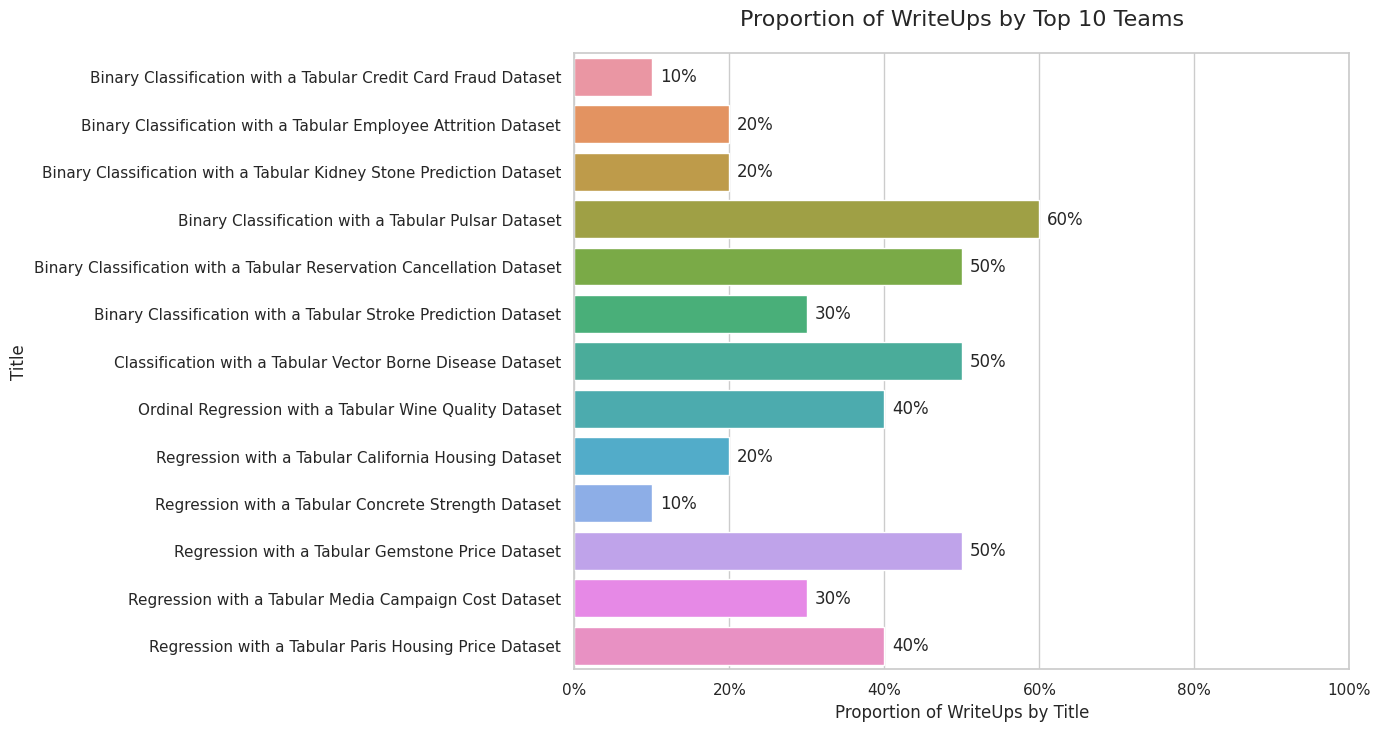

In [39]:
submission_counts['WriteUpExists'] = submission_counts['WriteUpForumTopicId'].apply(lambda x: 0 if x == 0 else 1)

# calculate the frequency (proportion) of write up existence for each title
writeup_frequency = submission_counts.groupby('Title')['WriteUpExists'].mean()

# create a figure and a subplot (you can customize the figure size)
fig, ax = plt.subplots(figsize=(10, 8))

# plot a bar chart
sns.barplot(y=writeup_frequency.index, x=writeup_frequency.values, ax=ax, orient='h')

# set chart labels and title
ax.set_ylabel('Title')
ax.set_xlabel('Proportion of WriteUps by Title')
ax.set_title('Proportion of WriteUps by Top 10 Teams', fontsize=16, pad=20)

# set x-axis limit to show percentages
ax.set_xlim(0, 1)

# convert x axis labels to percentages
ax.set_xticklabels(['{:.0f}%'.format(x*100) for x in ax.get_xticks()])

# Adding the text labels
rects = ax.patches
labels = writeup_frequency.values

for rect, label in zip(rects, labels):
    width = rect.get_width()
    ax.text(width+0.01, rect.get_y() + rect.get_height() / 2, f'{label:.0%}', ha='left', va='center')

# display the plot
plt.savefig("submission_writeups.png", bbox_inches = 'tight')  # 'bbox_inches = 'tight'' ensures the entire plot is saved